# 1. Setup Data
这里使用keras自带的preprocessing工具来读取数据文件夹，注意这对文件夹的结构有一定要求

注意这部分的指令在运行一次之后就不用在运行了

In [ ]:
"""
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
"""

In [2]:
import os, sys
current_dir = os.getcwd()
print(current_dir)

/home/aind2/DL_Notebooks/Dogs_vs_Cats


In [5]:
DATA_HOME_DIR = '/home/aind2/Data/Dogs_vs_Cats'
%cd $DATA_HOME_DIR

/home/aind2/Data/Dogs_vs_Cats


In [12]:
ls

test/  train/


## Copy file to Valid

In [15]:
#now i need to make a folder for validation
%mkdir valid

In [6]:
%cd $DATA_HOME_DIR/train

/home/aind2/Data/Dogs_vs_Cats/train


In [9]:
#move some file to validation set
from glob import glob
import numpy as np
g = glob('*.jpg')
shuffle = np.random.permutation(g)
for i in range(2000): os.rename(shuffle[i], DATA_HOME_DIR+'/valid/' + shuffle[i])

In [17]:
ls | wc

  23000   23000  577554


In [13]:
ls ../valid/| wc

   2000    2000   50234


In [15]:
ls | tail

dog.9993.jpg
dog.9994.jpg
dog.9995.jpg
dog.9996.jpg
dog.9997.jpg
dog.9998.jpg
dog.9999.jpg
dog.999.jpg
dog.99.jpg
dog.9.jpg


## Rearrange image files into their respective directories

In [18]:
%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/aind2/Data/Dogs_vs_Cats/valid
/home/aind2/Data/Dogs_vs_Cats/train


# 2. Read Data and Calculate Bottleneck Features

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# dimensions of our images.
img_width, img_height = 299, 299
batch_size = 40

nb_train_samples = 23000
nb_validation_samples = 2000

train_data_dir = "/home/aind2/Data/Dogs_vs_Cats/train"
valid_data_dir = "/home/aind2/Data/Dogs_vs_Cats/valid"

Using TensorFlow backend.


In [55]:
from keras import applications
base_model = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', pooling='max') #pooling 

这里是非常教科书的数据读取了，只不过这里不需要train，所以就没有读class

In [59]:
# calculate bottleneck features for training set
datagen = ImageDataGenerator(rescale=1. / 255)

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size, 
    class_mode=None, # this means our generator will only yield batches of data, no labels
    shuffle=False) # our data will be in order

bottleneck_features_train = base_model.predict_generator(generator, nb_train_samples // batch_size, verbose=1)

Found 23000 images belonging to 2 classes.
575/575 [==============================] - 381s   


注意保存的文件非常大，共有11gb，每张图有8\*8\*2048byte，比原图可能都大 (为了让文件小一些，base model里我选择了pooling，每张图变成2048，应该是小了64倍，同时输出的shape从4D变成2D，那么最后的top model不需要flatten了)

本来总共应该23000张图，但是不知道为什么bottleneck_features的维度对不上，所以后面的label可能是不对的 (似乎是batch size不能整除造成的,调整了之后就解决了)

In [56]:
generator = datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_validation = base_model.predict_generator(generator, nb_validation_samples // batch_size, verbose=1)

Found 2000 images belonging to 2 classes.
50/50 [==============================] - 33s    


In [5]:
print(bottleneck_features_train.shape)
print(bottleneck_features_validation.shape)

(23000, 2048)
(2000, 2048)


In [8]:
np.save("train",bottleneck_features_train)
np.save("valid",bottleneck_features_validation)

In [4]:
bottleneck_features_train = np.load("train.npz.npy")
bottleneck_features_validation = np.load("valid.npz.npy")

# Build Top Model and Training

In [6]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, BatchNormalization

#i don't know why the bottleneck features missed some images
train_labels = np.array([0] * 11500 + [1] * 11500)
validation_labels = np.array([0] * 1000 + [1] * 1000)

model = Sequential()
#model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model.add(Dense(256, activation='relu',input_shape=bottleneck_features_train.shape[1:]))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total para

In [10]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

model.fit(bottleneck_features_train, train_labels,
          epochs=5,
          batch_size=batch_size,
          validation_data=(bottleneck_features_validation, validation_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 8s - loss: 0.0658 - acc: 0.9808 - val_loss: 0.1344 - val_acc: 0.9780
Epoch 2/5
23000/23000 [==============================] - 3s - loss: 0.0475 - acc: 0.9868 - val_loss: 0.1443 - val_acc: 0.9735
Epoch 3/5
23000/23000 [==============================] - 3s - loss: 0.0419 - acc: 0.9886 - val_loss: 0.1300 - val_acc: 0.9810
Epoch 4/5
23000/23000 [==============================] - 3s - loss: 0.0381 - acc: 0.9900 - val_loss: 0.1060 - val_acc: 0.9790
Epoch 5/5
23000/23000 [==============================] - 3s - loss: 0.0359 - acc: 0.9903 - val_loss: 0.1270 - val_acc: 0.9790


In [11]:
model.fit(bottleneck_features_train, train_labels,
          epochs=5,
          batch_size=batch_size,
          validation_data=(bottleneck_features_validation, validation_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 3s - loss: 0.0333 - acc: 0.9919 - val_loss: 0.1045 - val_acc: 0.9785
Epoch 2/5
23000/23000 [==============================] - 4s - loss: 0.0324 - acc: 0.9923 - val_loss: 0.1255 - val_acc: 0.9815
Epoch 3/5
23000/23000 [==============================] - 4s - loss: 0.0365 - acc: 0.9909 - val_loss: 0.1874 - val_acc: 0.9790
Epoch 4/5
23000/23000 [==============================] - 4s - loss: 0.0417 - acc: 0.9909 - val_loss: 0.1068 - val_acc: 0.9795
Epoch 5/5
23000/23000 [==============================] - 3s - loss: 0.0412 - acc: 0.9908 - val_loss: 0.2555 - val_acc: 0.9755


In [18]:
model.optimizer.lr = 0.0001
model.fit(bottleneck_features_train, train_labels,
          epochs=5,
          batch_size=batch_size,
          validation_data=(bottleneck_features_validation, validation_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 3s - loss: 0.0593 - acc: 0.9881 - val_loss: 0.1116 - val_acc: 0.9765
Epoch 2/5
23000/23000 [==============================] - 3s - loss: 0.0579 - acc: 0.9881 - val_loss: 0.0917 - val_acc: 0.9770
Epoch 3/5
23000/23000 [==============================] - 3s - loss: 0.0566 - acc: 0.9883 - val_loss: 0.0970 - val_acc: 0.9765
Epoch 4/5
23000/23000 [==============================] - 3s - loss: 0.0566 - acc: 0.9885 - val_loss: 0.1217 - val_acc: 0.9760
Epoch 5/5
23000/23000 [==============================] - 3s - loss: 0.0553 - acc: 0.9888 - val_loss: 0.1145 - val_acc: 0.9770


In [13]:
model.save_weights('bottleneck_fc_model.h5')

In [7]:
model.load_weights("bottleneck_fc_model.h5")

# Some Visualization

一种是用generator读了图片再plot，注意首先要scale，其次generator默认会把图片弄成方的

keras.preprocessing.image 有一个load_img，可以从文件名读取image然后用imshow画出来

In [21]:
gen = ImageDataGenerator(rescale=1./255) #without rescale imshow will show strange color

batches = gen.flow_from_directory(
    valid_data_dir,
    batch_size=4, 
    class_mode="categorical",
    shuffle=False) 

Found 2000 images belonging to 2 classes.


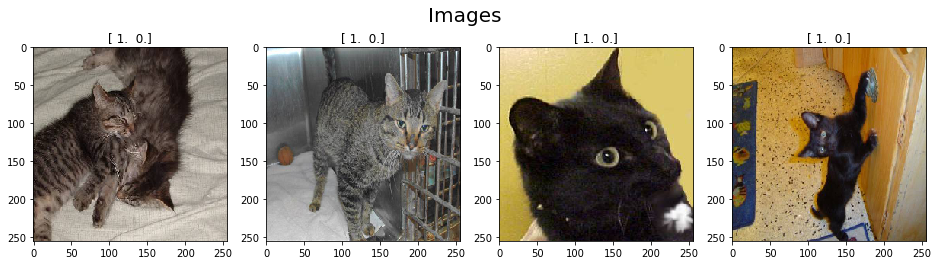

In [22]:
import matplotlib.pyplot as plt

# visualize augmented images
fig = plt.figure(figsize=(16,4))
batch = batches.next()
for i in range(0, 4):
    ax = fig.add_subplot(1, 4, i+1)
    ax.imshow(batch[0][i])

    y = batch[1][i]
    ax.set_title(str(y))

fig.suptitle('Images', fontsize=20)
plt.show()

## test some results

In [58]:
pred = model.predict_classes(bottleneck_features_validation, verbose=0)#i did not shuffle when prepare bottleneck
pred_prob = model.predict(bottleneck_features_validation, verbose=0)
pred = pred.flatten()
pred_prob = pred_prob.flatten()

In [41]:
incorrect = np.where(pred!=batches.classes)[0]

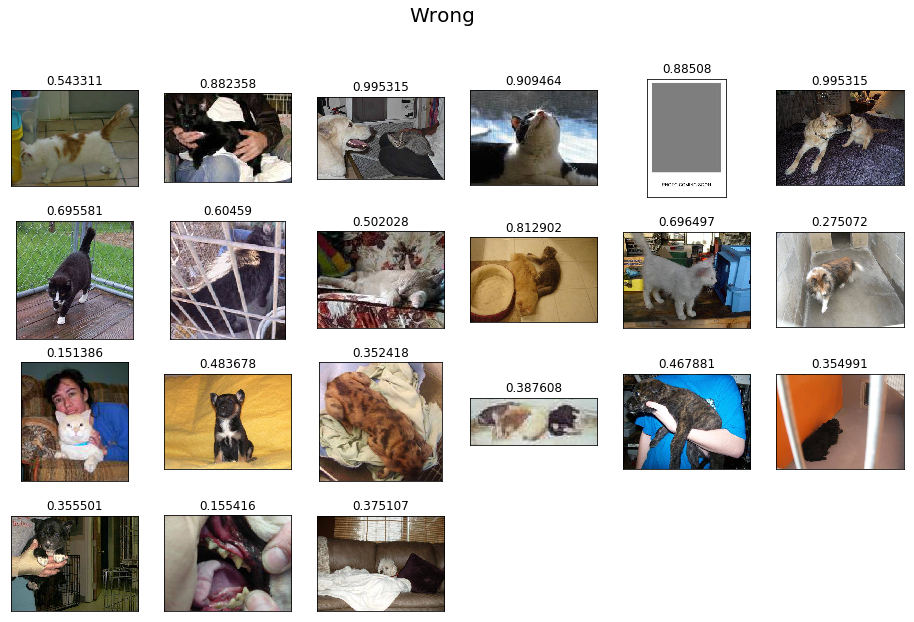

In [52]:
from keras.preprocessing import image
valid_path = "/home/aind2/Data/Dogs_vs_Cats/valid/"

fig = plt.figure(figsize=(16,10))
for i in range(len(incorrect)):
    ax = fig.add_subplot(4, 6, i+1,xticks = [], yticks = [])
    img = image.load_img(valid_path + batches.filenames[incorrect[i]])
    ax.set_title(pred_prob[incorrect[i]])
    plt.imshow(img)

fig.suptitle('Wrong', fontsize=20)
plt.show()

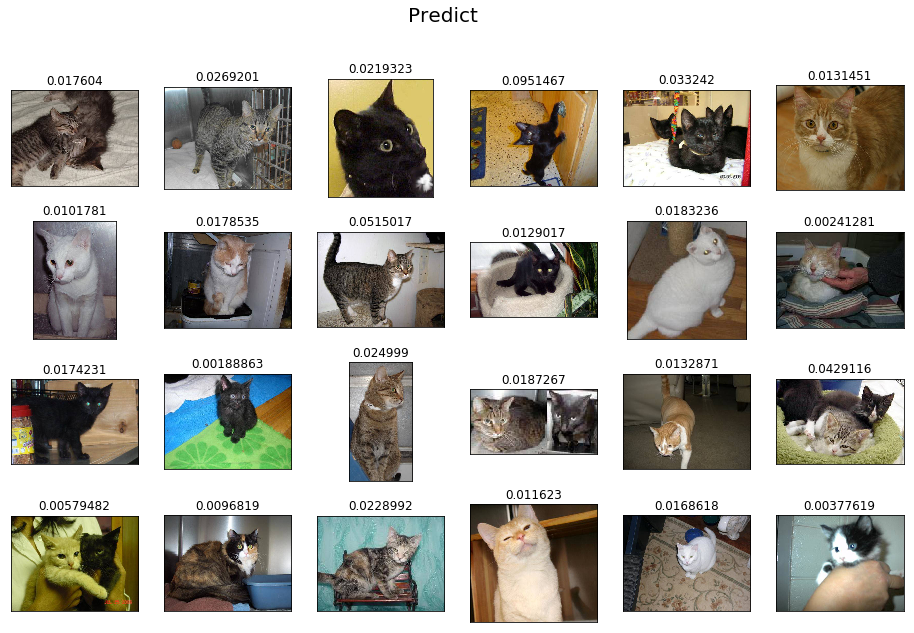

In [55]:
fig = plt.figure(figsize=(16,10))
for i in range(24):
    ax = fig.add_subplot(4, 6, i+1,xticks = [], yticks = [])
    img = image.load_img(valid_path + batches.filenames[i])
    ax.set_title(pred_prob[i])
    plt.imshow(img)

fig.suptitle('Predict', fontsize=20)
plt.show()

# Future works

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
    
看一下这个文章如何用很少的数据配合augmentation做的

同时文章最后还提到了可以Fine-tuning the top layers of a a pre-trained network

In [125]:
cd DL_Notebooks/Dogs_vs_Cats/

/home/aind2/DL_Notebooks/Dogs_vs_Cats


In [126]:
ls -lah

total 202M
drwxrwxr-x 3 aind2 aind2 4.0K Sep 26 21:54 ./
drwxrwxr-x 7 aind2 aind2 4.0K Sep 26 20:09 ../
-rw-rw-r-- 1 aind2 aind2 2.3M Sep 26 20:29 bottleneck_fc_model.h5
-rw-rw-r-- 1 aind2 aind2 359K Sep 26 21:54 Dogs_vs_Cats.ipynb
drwxr-xr-x 2 aind2 aind2 4.0K Sep 26 03:08 .ipynb_checkpoints/
-rw-r--r-- 1 aind2 aind2  30K Sep 26 20:33 keras_catdog_small.ipynb
-rw-r--r-- 1 aind2 aind2  42K Sep 26 01:31 kg-dogscats-ensemble.ipynb
-rw-r--r-- 1 aind2 aind2 3.0M Sep 26 02:43 kg-dogs_cats_redux.ipynb
-rw-rw-r-- 1 aind2 aind2 180M Sep 26 20:25 train.npz.npy
-rw-rw-r-- 1 aind2 aind2  16M Sep 26 20:25 valid.npz.npy
